Q: What is the estimate kband background?

In [1]:
import numpy as np
%matplotlib inline
from pylab import *

import scipy.integrate

from collections import namedtuple

import numpy as np
%matplotlib inline
from pylab import *

from astropy import units as ur
from astropy import constants as cc
import astropy.modeling.blackbody



In [2]:
hc = cc.h * cc.c
micron = ur.meter * 1e-6
K = ur.Kelvin



In [3]:


lam = np.arange(2000, 2500) * ur.nanometer
epp = hc/lam
Temp = 299 * K
L_e_Omega_lam = astropy.modeling.blackbody.blackbody_lambda(lam, Temp)

number_mirrors = 3

emissivity = 1 - 0.97**(2)

In [4]:
L_e_Omega_lam

<Quantity [1.32351701e-05, 1.33618311e-05, 1.34895589e-05, 1.36183614e-05,
           1.37482463e-05, 1.38792212e-05, 1.40112940e-05, 1.41444726e-05,
           1.42787647e-05, 1.44141784e-05, 1.45507216e-05, 1.46884024e-05,
           1.48272288e-05, 1.49672090e-05, 1.51083510e-05, 1.52506632e-05,
           1.53941537e-05, 1.55388309e-05, 1.56847032e-05, 1.58317789e-05,
           1.59800664e-05, 1.61295743e-05, 1.62803111e-05, 1.64322854e-05,
           1.65855058e-05, 1.67399810e-05, 1.68957197e-05, 1.70527308e-05,
           1.72110231e-05, 1.73706054e-05, 1.75314866e-05, 1.76936758e-05,
           1.78571820e-05, 1.80220142e-05, 1.81881816e-05, 1.83556933e-05,
           1.85245587e-05, 1.86947869e-05, 1.88663873e-05, 1.90393693e-05,
           1.92137423e-05, 1.93895158e-05, 1.95666994e-05, 1.97453025e-05,
           1.99253349e-05, 2.01068063e-05, 2.02897264e-05, 2.04741050e-05,
           2.06599519e-05, 2.08472770e-05, 2.10360904e-05, 2.12264020e-05,
           2.14182218e-05

In [5]:
Amirror = 30 * ur.meter**2 
Omega_1as2 = 1/4.25e10 * ur.steradian

Phi_lam = L_e_Omega_lam * Amirror * Omega_1as2 * emissivity

In [6]:
Phi_lam.to(ur.Watt/ur.angstrom)
N_lam = Phi_lam/epp

In [7]:
def angle_to_omega(rad):
    
    return np.pi*np.sin(rad)**2

In [8]:
def fnum_to_Omega(fnum):
    " See eq. 24 https://www.labsphere.com/site/assets/files/2551/integrating_sphere_theory_apps_tech_guide.pdf"
    
    return np.pi/(4*fnum*fnum) * ur.steradian

In [9]:
fnum_to_Omega(1.5)

<Quantity 0.34906585 sr>

In [10]:
astropy.version.version

'3.0.3'

In [ ]:
astropy.modeling.blackbody.blackbody_lambda

In [11]:
def model(lam, number_mirrors=3, temp=299*K, D_tel=10*ur.meter, fnum=2, reflectivity=0.96,
         efficiency = .35):
    """ Return BB curve for the reflective component of a telescope system
    
    Args:
        lam[] -- Wavelengths [L] to consider
        number_mirrors -- Number of warm reflections in the system
        temp -- The warm temperature [Temp]
        D_tel -- Telescope diaemter [L]
        fnum -- The focal ratio of the camera
        reflectivity -- Reflectivity of the bounce
        efficiency -- System efficiency
        
    Returns:
        Spectrum in units of 1/(s Angstrom) with same dimensionality as lam
     """
    epp = hc/lam

    # Specific spectral radiance in photon / sr/ m2 / bw
    L_e_Omega_lam = astropy.modeling.blackbody.blackbody_lambda(lam, temp)
    emissivity = 1 - reflectivity**(number_mirrors)
    print("Emissivity of system is: %3.2f " % emissivity)
        
    Omega = fnum_to_Omega(fnum)
    A_pixel = (18*ur.micron)**2   
    A_1as = (D_tel*fnum/206265)**2
    
    AREA = A_1as

    Phi_lam = L_e_Omega_lam * Omega * AREA * emissivity # Phi_lam is [Power]/[Bandwidth]
    N_lam = Phi_lam/epp # N_lam is [Hz]/[Bandwidth]
    
    nlam = N_lam.to(ur.Hertz/ur.angstrom) / (ur.Hertz/ur.angstrom) * efficiency
    flam = L_e_Omega_lam * Omega * emissivity * efficiency

    return nlam, flam

Emissivity of system is: 0.12 
Emissivity of system is: 0.08 
Emissivity of system is: 0.12 
Emissivity of system is: 0.12 


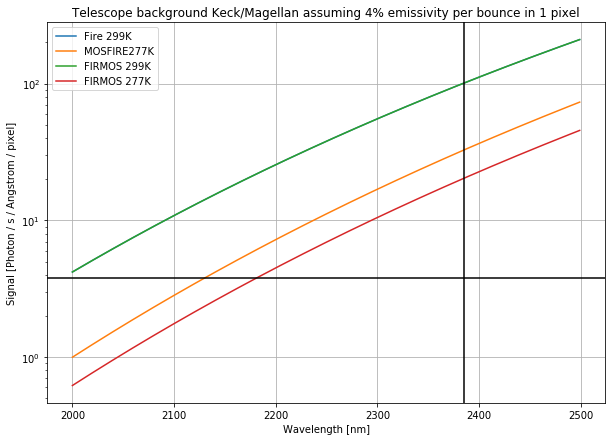

In [12]:

m = ur.meter
lam = np.arange(2000, 2500) * ur.nm

figure(figsize=(10,7))
semilogy(lam, model(lam, number_mirrors=3, fnum=3.54, D_tel=6.5*m, temp=299*K)[0])
semilogy(lam, model(lam, number_mirrors=2, fnum=1.8, D_tel=10*m, temp=277*K)[0])

semilogy(lam, model(lam, number_mirrors=3, fnum=1.6, D_tel=6.5*m, temp=299*K)[0])
semilogy(lam, model(lam, number_mirrors=3, fnum=1.6, D_tel=6.5*m, temp=277*K)[0])


legend(["Fire 299K", "MOSFIRE277K", "FIRMOS 299K", "FIRMOS 277K"])
xlabel("Wavelength [nm]")
ylabel("Signal [Photon / s / Angstrom / pixel]")
title("Telescope background Keck/Magellan assuming 4% emissivity per bounce in 1 pixel")
grid(True)


# The crosshair comes from GWEN, see info at end of this file
axhline(3.8, color='black')
axvline(2385, color='black')

In [13]:
_,flam = model(lam, number_mirrors=3, fnum=3.54, D_tel=6.5*m, temp=299*K)


(flam*lam**2/cc.c).to(ur.Jansky)

Emissivity of system is: 0.12 


<Quantity [  446492.22942807,   451216.04973827,   455984.71173449,
             460798.58928753,   465658.05891681,   470563.49980541,
             475515.29381515,   480513.82550173,   485559.48212996,
             490652.65368901,   495793.73290775,   500983.11527011,
             506221.19903057,   511508.38522965,   516845.07770947,
             522231.6831294 ,   527668.61098172,   533156.27360742,
             538695.08621194,   544285.46688111,   549927.83659707,
             555622.6192542 ,   561370.24167527,   567171.13362749,
             573025.7278387 ,   578934.46001364,   584897.7688502 ,
             590916.09605582,   596989.88636389,   603119.58755024,
             609305.65044968,   615548.52897265,   621848.6801218 ,
             628206.56400881,   634622.64387113,   641097.38608885,
             647631.26020162,   654224.73892562,   660878.2981706 ,
             667592.417057  ,   674367.5779331 ,   681204.26639223,
             688102.9712901 ,   695064.18476212,

Emissivity of system is: 0.12 


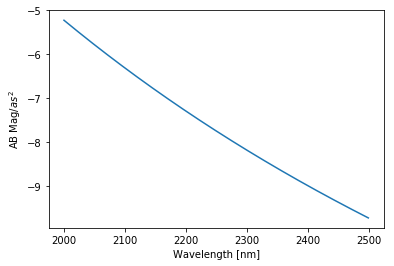

In [14]:
lam = np.arange(2000, 2500) * ur.nm
_, flam = model(lam, number_mirrors=3, fnum=3.54, D_tel=6.5*m, temp=299*K)

fjy = (flam * lam**2/cc.c)

mag = -2.5 * np.log10(fjy/(3631 * ur.Jansky))


plot(lam, mag)
#ylim(30,10)
xlabel("Wavelength [nm]")
ylabel("AB Mag/$as^2$")

From GWEN Mosfire background in K
23847.099  3.01282e-17 ergs/s/cm^2/A

8.34641103 × 10-13 erg

In [15]:
epp=hc/(23847*ur.Angstrom)
epp.to(ur.erg)

<Quantity 8.3299611e-13 erg>

In [16]:

Sig = 3.01e-17

epp = 8.33e-13 # erg
Atel = 760000 # cm2

pixels = 2.7

Sig/epp*Atel/pixels**2 # Photon/s/Angstrom

3.7671035492386253